In [1]:
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# co-expression network analysis packages:
library(WGCNA)
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

Attaching SeuratObject

Attaching sp

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




In [2]:
source('../00_preprocessing/preprocessing.R')

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, 

In [6]:
source('../01_milo/milo.R')

In [3]:
obj_other = qs::qread('../00_preprocessing/_targets/objects/exp_labelled_other')

In [9]:
obj_MOL = single_split(obj_other, 'MOL')

In [10]:
obj_Astrocytes = single_split(obj_other, 'Astrocytes')

In [11]:
obj_NFOL = single_split(obj_other, 'NFOL')

In [12]:
seurat_list = list(obj_MOL, obj_Astrocytes, obj_NFOL)

In [14]:
merge(seurat_list[[1]], c(seurat_list[[2]])

An object of class Seurat 
56583 features across 15261 samples within 3 assays 
Active assay: SCT (24262 features, 0 variable features)
 2 other assays present: RNA, integrated

In [18]:
unlist(seurat_list[2:3])

[[1]]
An object of class Seurat 
56583 features across 11238 samples within 3 assays 
Active assay: SCT (24262 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

[[2]]
An object of class Seurat 
56583 features across 454 samples within 3 assays 
Active assay: SCT (24262 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap


In [19]:
merge(seurat_list[[1]], c(unlist(seurat_list[2:3])))

An object of class Seurat 
56583 features across 15715 samples within 3 assays 
Active assay: SCT (24262 features, 0 variable features)
 2 other assays present: RNA, integrated

In [20]:
merge(seurat_list[[1]], c(seurat_list[2:3]))

An object of class Seurat 
56583 features across 15715 samples within 3 assays 
Active assay: SCT (24262 features, 0 variable features)
 2 other assays present: RNA, integrated

In [21]:
obj <- SetupForWGCNA(
  obj_MOL,
  gene_select = "fraction", # the gene selection approach
  fraction = 0.05, # fraction of cells that a gene needs to be expressed in order to be included
  wgcna_name = "MOL" # the name of the hdWGCNA experiment
)

In [23]:
# construct metacells  in each group
obj <- MetacellsByGroups(
  seurat_obj = obj,
  group.by = c("labels", "hash.mcl.ID"), # specify the columns in seurat_obj@meta.data to group by
  k = 25, # nearest-neighbors parameter
  max_shared = 10, # maximum number of shared cells between two metacells
  ident.group = 'labels', # set the Idents of the metacell seurat object
  min_cells = 25,
  assay = "SCT",
  slot="counts",
  mode="sum",
  verbose=TRUE
)

Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 4.93589743589744
Median shared cells bin-bin: 5

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 4.54166666666667
Median shared cells bin-bin: 5

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean shared cells bin-bin: 4.62091503267974
Median shared cells bin-bin: 4

Warning message in (function (seurat_obj, name = "agg", ident.group = "seurat_clusters", :
"On average, more than 10% of cells are shared between paired bins."
Overlap QC metrics:
Cells per bin: 25
Maximum shared cells bin-bin: 10
Mean sha

ERROR: Error in apply(cell_sample, 1, function(x) {: dim(X) must have a positive length


In [24]:
# normalize metacell expression matrix:
obj <- NormalizeMetacells(obj)
obj <- ScaleMetacells(obj, features=VariableFeatures(obj))
obj <- RunPCAMetacells(obj, features=VariableFeatures(obj))
obj <- RunHarmonyMetacells(obj, group.by.vars="hash.mcl.ID")
obj <- RunUMAPMetacells(obj, reduction='harmony', dims=1:15)

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 9 features requested have zero variance (running reduction without them): Slc47a1, Cga, Cib4, Ly6c1, Slc6a13, Prdm6, Aldh1a2, Cldn5, Top2a"
PC_ 1 
Positive:  Mapk4, Glis3, Plce1, Prex2, Sox6, Spon1, Pitpnc1, Ptprt, Mertk, Slit2 
	   Lhfp, Slc39a12, Rmst, Bcl2, Adcy2, Tmem164, ENSMUSG00000097156, Gli3, Fat3, Slc4a4 
	   Nebl, Ntrk2, Gpc6, Zeb1, Rgs20, Ptprz1, Cables1, Rorb, Trpm3, Dgkb 
Negative:  Mbp, Slc24a2, Map7, Mobp, Zfp536, Nkain2, Ctnna3, Slc44a1, Plp1, Dscaml1 
	   Prima1, Mog, Tmeff2, Sytl2, ENSMUSG00000101179, Jakmip3, Klhl2, Cldn14, D7Ertd443e, Carns1 
	   Tnni1, Pllp, Dock10, Prr5l, Itgad, Cyp2j12, ENSMUSG00000116885, Ppp1r16b, Sec14l5, Cacna2d4 
PC_ 2 
Positive:  Kcnma1, Hif3a, Itgad, Ptgds, Fkbp5, Zfand4, Ddc, Zbtb16, Tmod2, Klf13 
	   Sgk1, St3gal3, Mast3, Rhoj, Cdc42bpa, Rcan2, Pakap, Pdxk, Tspan2, Agap1 
	   Kndc1, Ank3, Gli2, Cdh18, Elm

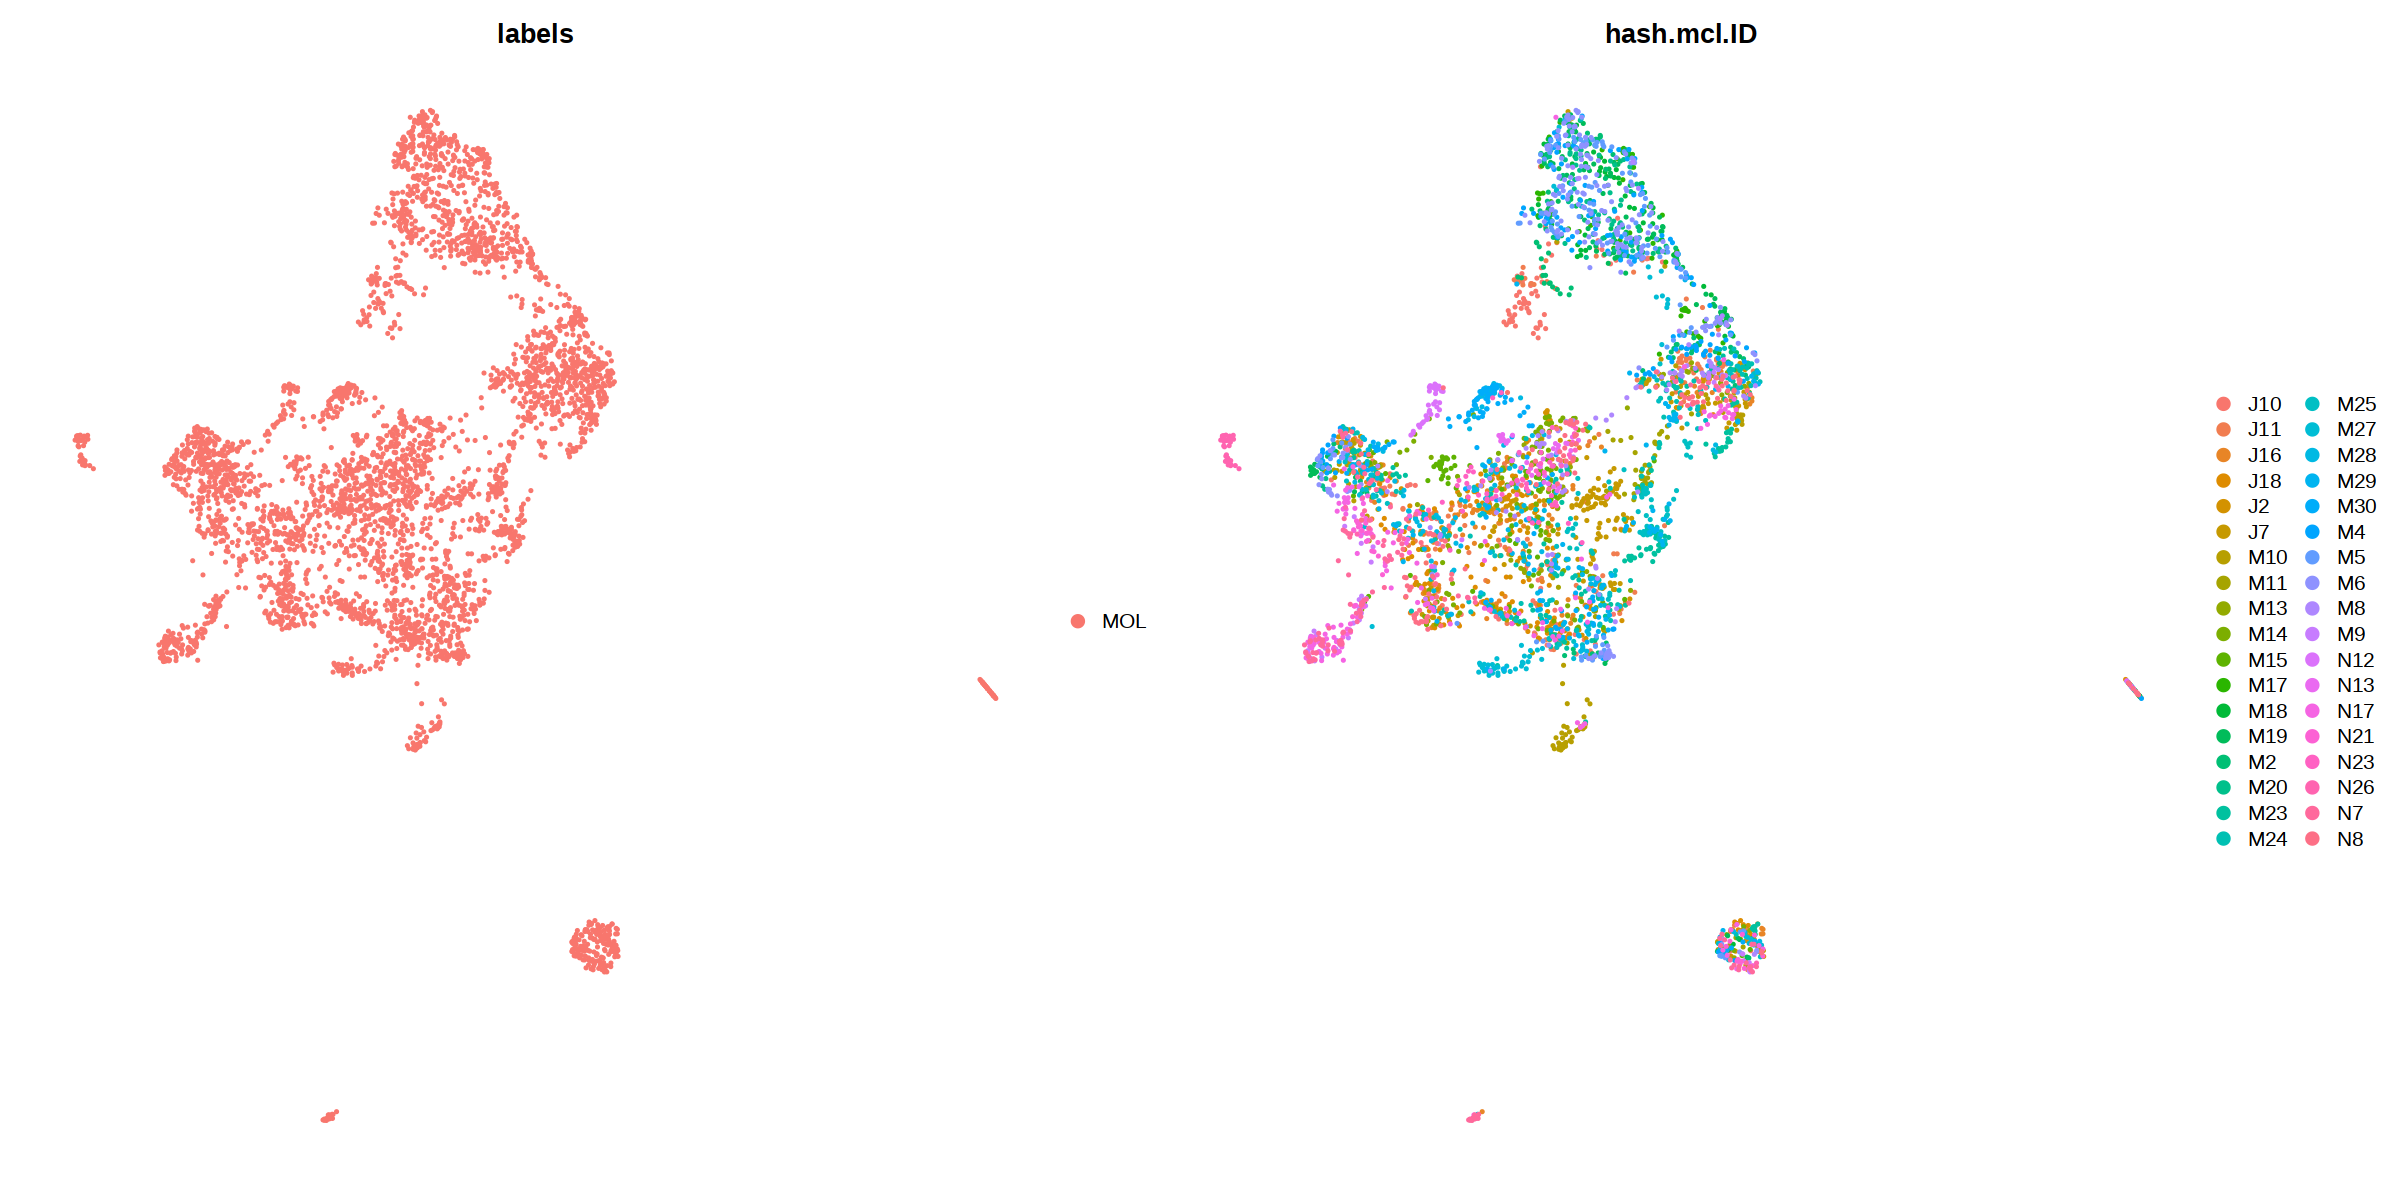

In [25]:
options(repr.plot.width=20, repr.plot.height=10)
p1 <- DimPlotMetacells(obj, group.by='labels') + umap_theme() + ggtitle("labels")
p2 <- DimPlotMetacells(obj, group.by="hash.mcl.ID") + umap_theme() + ggtitle("hash.mcl.ID")

p1 | p2

In [26]:
obj <- SetDatExpr(
  obj,
  group_name = "MOL", # the name of the group of interest in the group.by column
  group.by='labels', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'SCT', # using RNA assay
  slot = 'data' # using normalized data
)

pickSoftThreshold: will use block size 5678.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5678 of 7879


Warning message:
"executing %dopar% sequentially: no parallel backend registered"
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
"bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD."
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


   ..working on genes 5679 through 7879 of 7879


Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
"bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD."
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k.   max.k.
1      1   0.3130 118.00          0.948 3.95e+03  3.95e+03 4010.000
2      2   0.2370  51.30          0.965 1.98e+03  1.98e+03 2040.000
3      3   0.0857  19.20          0.976 9.97e+02  9.96e+02 1050.000
4      4   0.0396   9.99          0.966 5.03e+02  5.01e+02  538.000
5      5   0.0418  -8.04          0.933 2.54e+02  2.53e+02  282.000
6      6   0.2540 -15.90          0.815 1.28e+02  1.28e+02  151.000
7      7   0.4940 -17.00          0.722 6.51e+01  6.46e+01   82.400
8      8   0.7660 -16.20          0.762 3.31e+01  3.27e+01   46.300
9      9   0.9010 -13.80          0.876 1.68e+01  1.66e+01   26.900
10    10   0.9260 -11.10          0.956 8.60e+00  8.44e+00   16.300
11    12   0.8760  -6.37          0.968 2.26e+00  2.19e+00    6.860
12    14   0.8530  -4.09          0.908 6.01e-01  5.72e-01    3.430
13    16   0.8830  -3.00          0.938 1.63e-01  1.50e-01    1.950
14    18   0.9060  -2.38          0.932 4.59e-02

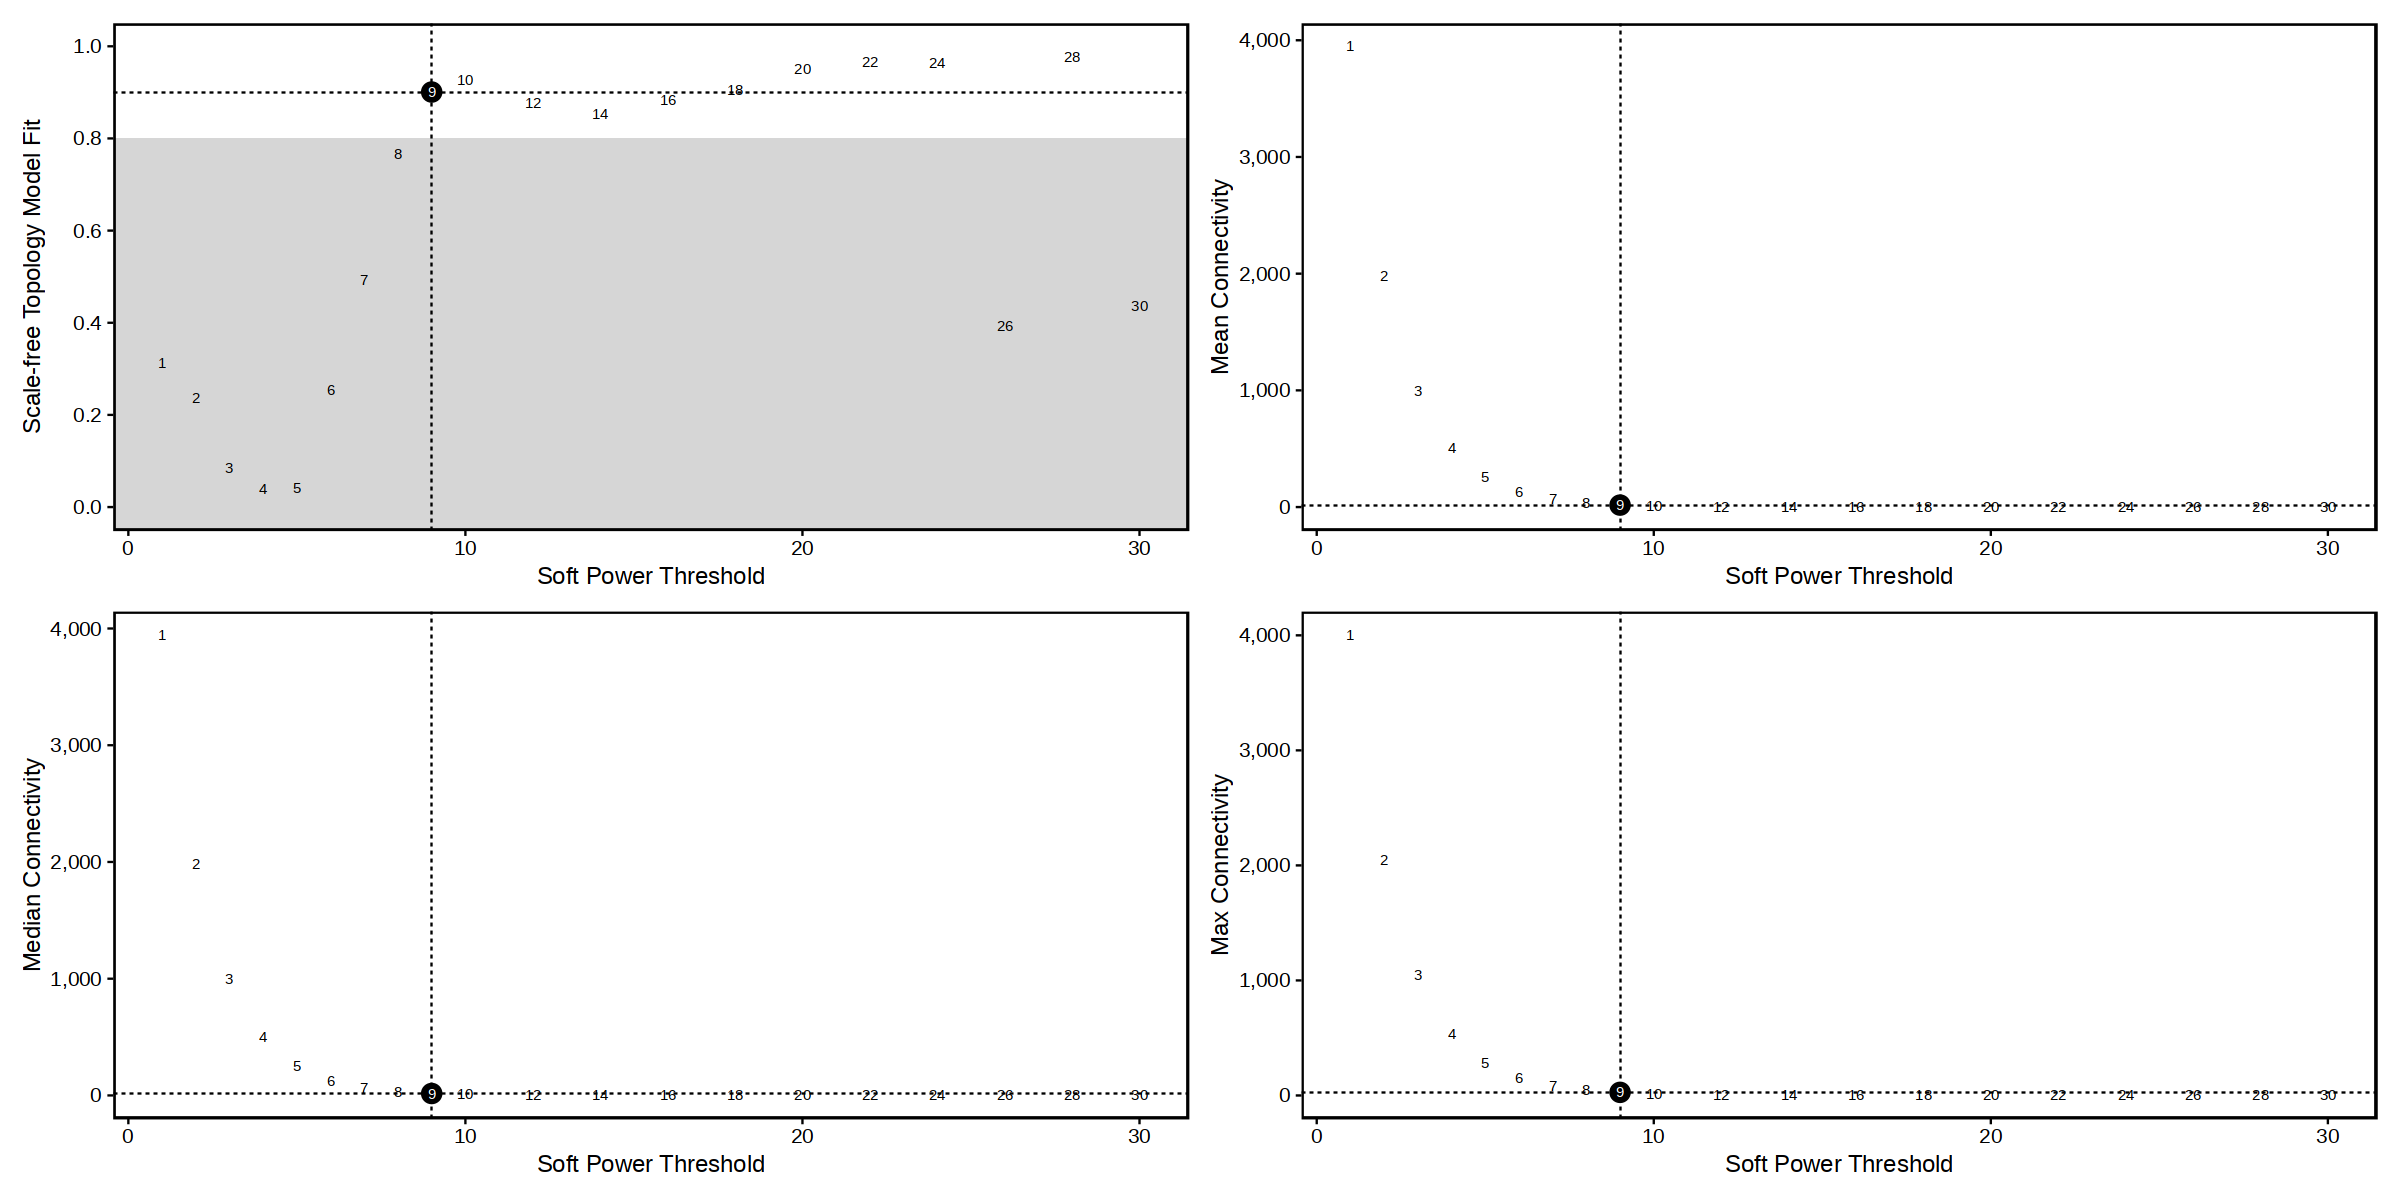

In [27]:
# Test different soft powers:
obj <- TestSoftPowers(
  obj,
  networkType = 'signed' # you can also use "unsigned" or "signed hybrid"
)

# plot the results:
plot_list <- PlotSoftPowers(obj)

# assemble with patchwork
wrap_plots(plot_list, ncol=2)

In [30]:
# construct co-expression network:
obj <- ConstructNetwork(
  obj,
  setDatExpr=FALSE,
  tom_name = 'MOL', # name of the topoligical overlap matrix written to disk,
  overwrite_tom = TRUE
)

Warning message in ConstructNetwork(obj, setDatExpr = FALSE, tom_name = "MOL", overwrite_tom = TRUE):
"Overwriting TOM TOM/MOL_TOM.rda"


Soft power not provided. Automatically using the lowest power that meets 0.8 scale-free topology fit. Using soft_power = 9
 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


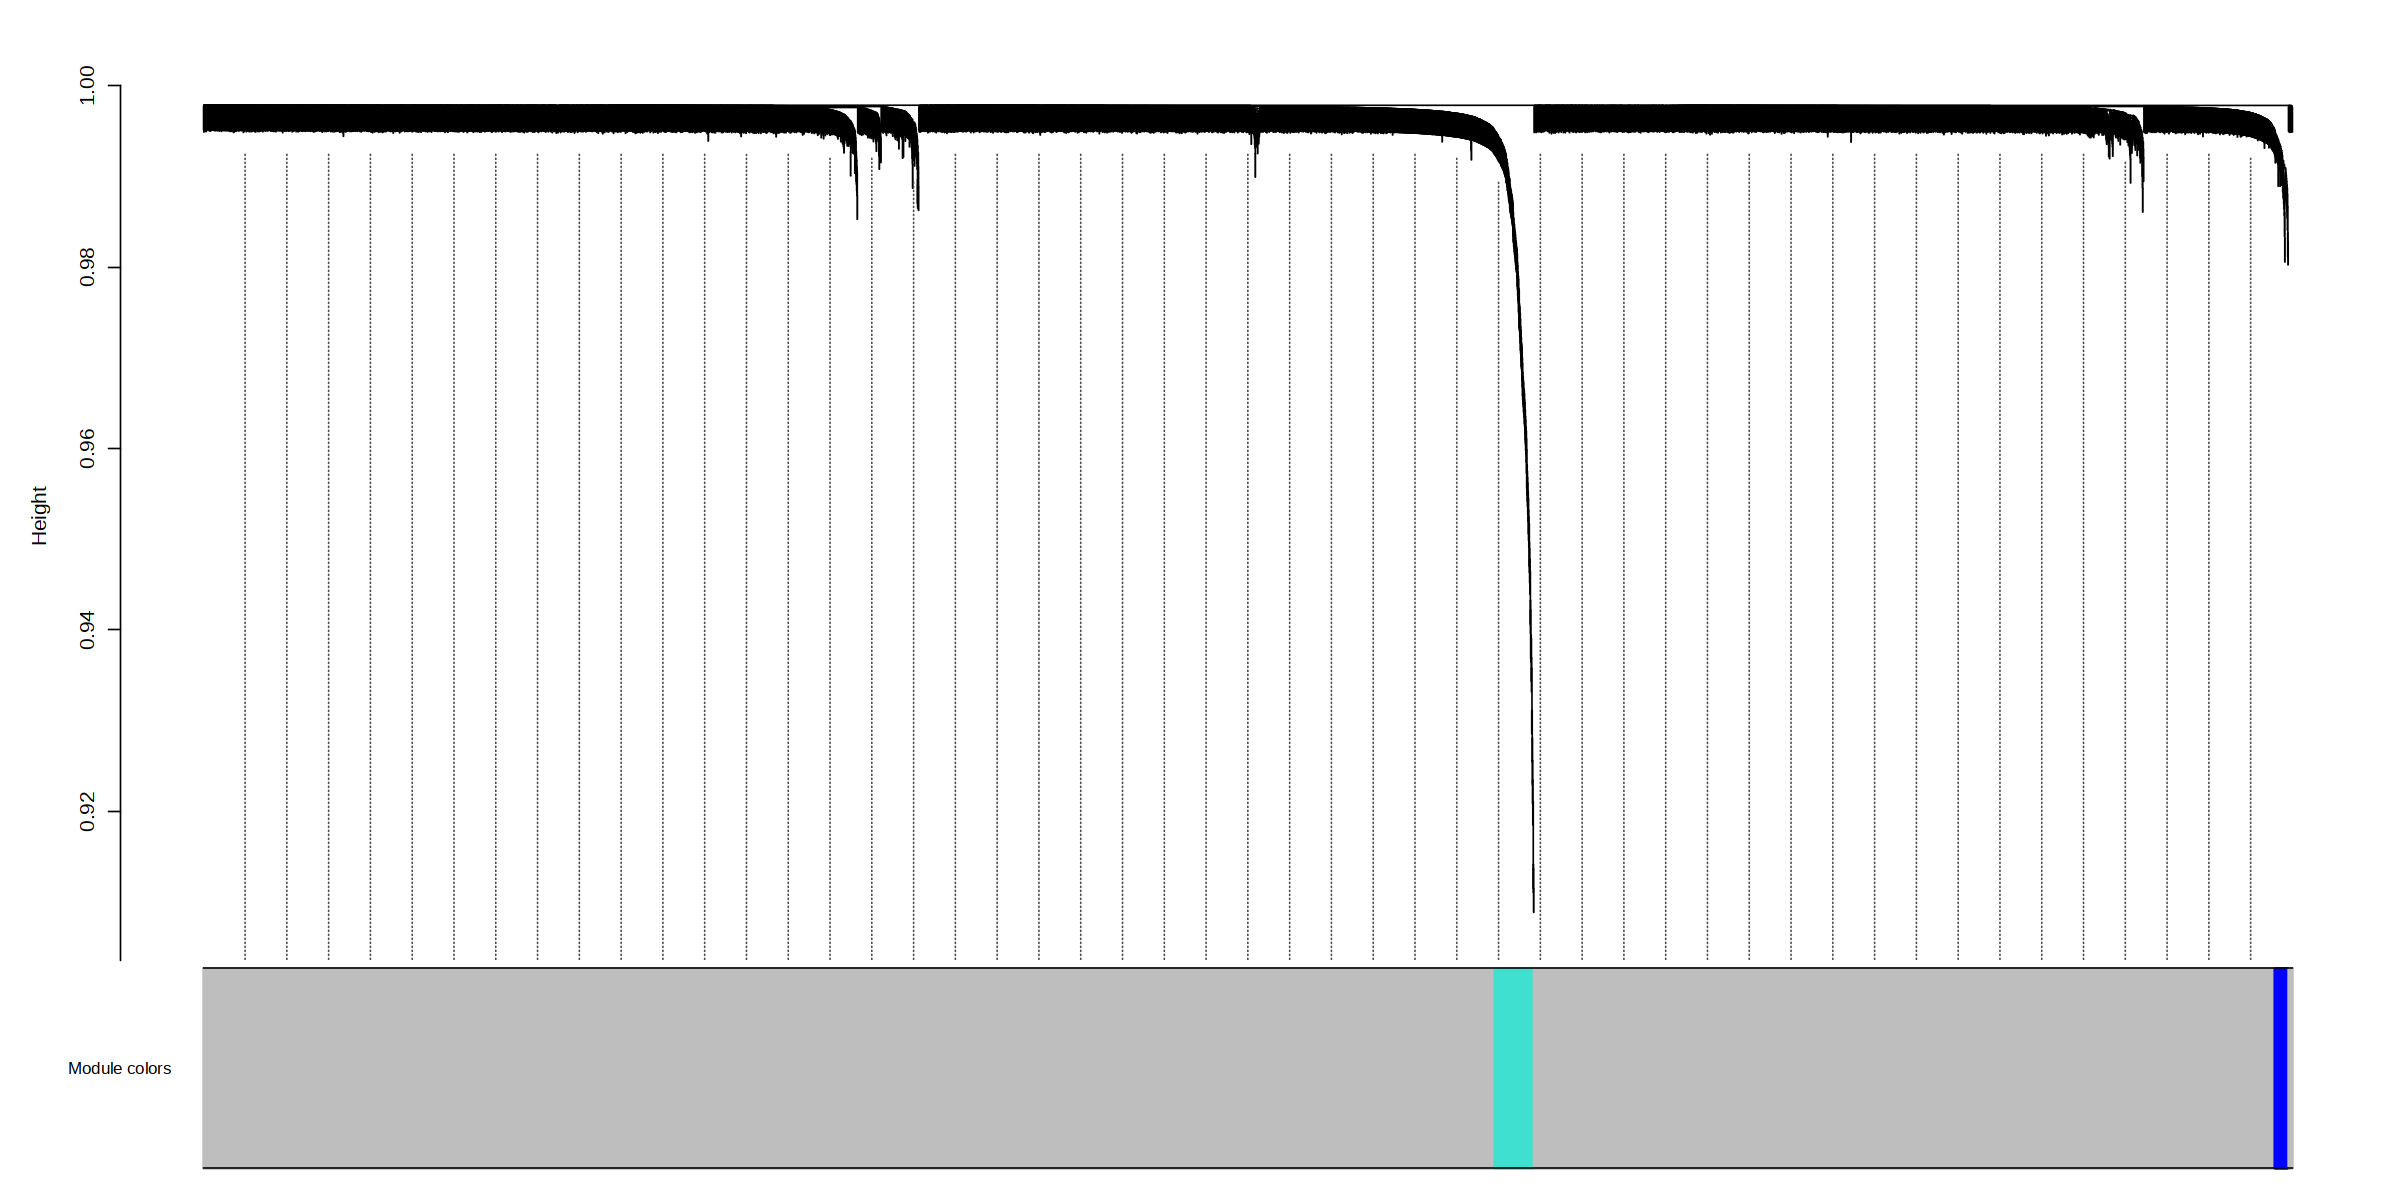

In [31]:
PlotDendrogram(obj)

In [32]:
# need to run ScaleData first or else harmony throws an error:
obj <- ScaleData(obj, features=VariableFeatures(obj))

# compute all MEs in the full single-cell dataset
obj <- ModuleEigengenes(
 obj,
 group.by.vars="hash.mcl.ID"
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_"
pcagrey_ 1 
Positive:  Mbp, Man1a, Mobp, Plp1, Sytl2, Zfp536, Jakmip3, Gm5087, Cacna2d4, Cldn14 
	   Phldb1, Klhl2, Kndc1, Gm10863, Sgk2, Padi2, Sspo, Mog, Cerox1, Sbf1 
	   Synj2, A330076H08Rik, Tmeff2, Mical3, Vldlr, 1700047M11Rik, Synpr, Carns1, Mal, E2f3 
Negative:  ENSMUSG00000098178, Npas3, Adgrl3, Adgrb3, Nav3, Igf1r, Meg3, Lrrc4c, Spock3, Cdk8 
	   Lsamp, Tenm2, Cadm1, Ogdhl, Magi2, Neat1, Cdh20, Grm3, Hivep2, Robo1 
	   Marchf1, Ccser1, Maml2, Il33, Cacna2d3, Cep85l, Arhgap21, Nr3c2, Dock9, Macf1 
pcagrey_ 2 
Positive:  Anln, Dgki, Slco3a1, Spock3, Usp31, A330049N07Rik, Zdhhc20, ENSMUSG00000109233, Neat1, Dock9 
	   ENSMUSG00000116885, Prr5l, Grm3, Hapln2, Enpp6, Ctnna2, Agmo, Tln2, K

[1] "turquoise"


Centering and scaling data matrix

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_"
pcaturquoise_ 1 
Positive:  Malat1, Pcsk1n, Actb, Ddx5, Snhg11, Camk1d, Son, Cst3, Magi1, Ogt 
	   Kcnip4, Apoe, Gria2, Nalf1, Ctnnd2, Prkg1, Chd9, Gabrg3, Ptch1, Abr 
	   Rtn1, Tspan7, Cacna1d, Ssbp2, Fry, Syne1, Map2, Pdlim5, Arhgap26, Rfx3 
Negative:  Mapk4, Glis3, Plce1, Prex2, Lhfp, Slc39a12, Utrn, Tmem164, Spon1, Bcl2 
	   Slit2, Sox6, Adcy2, Mertk, Pitpnc1, Rgs20, Rmst, ENSMUSG00000097156, Gli3, Ptprt 
	   Rorb, Fat3, Sox5, Nrcam, Csgalnact1, Ccdc85a, Col23a1, Carmil1, Gpc6, Nebl 
pcaturquoise_ 2 
Positive:  Slc4a4, Sox6, Sox5, Ntm, Gpc5, Fat3, Nrcam, Ptprt, Wdr17, Pitpnc1 
	   Nebl, Slc1a2, Dgkb, Zeb1, Ptprz1, Prex2, Gpc6, Trpm3, Plcb1, Ntrk2 
	   Spon1, Farp1, Kcnd2, Fg

[1] "blue"


Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
"You're computing too large a percentage of total singular values, use a standard svd instead."
Warning message in irlba(A = t(x = object), nv = npcs, ...):
"did not converge--results might be invalid!; try increasing work or maxit"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_"
Warning message:
"Requested number is larger than the number of available items (52). Setting to 52."
Warning message:
"Requested number is larger than the number of available items (52). Setting to 52."
Warning message:
"Requested number is larger than the number of available items (52). Setting to 52."
Warning message:
"Requested number is larger than the number of available items (52). Setting to 52."


In [33]:
# harmonized module eigengenes:
hMEs <- GetMEs(obj)

# module eigengenes:
MEs <- GetMEs(obj, harmonized=FALSE)

In [34]:
# compute eigengene-based connectivity (kME):
obj <- ModuleConnectivity(
  obj,
  group.by = 'labels', group_name = 'MOL'
)

Warning message in bicor(datExpr, datME, , use = "p"):
"bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD."


In [35]:
obj <- ResetModuleNames(
  obj,
  new_name = "MOL-M"
)

[1] "MOL-M1"
[1] "MOL-M2"
[1] "MOL-M1"
[1] "MOL-M2"


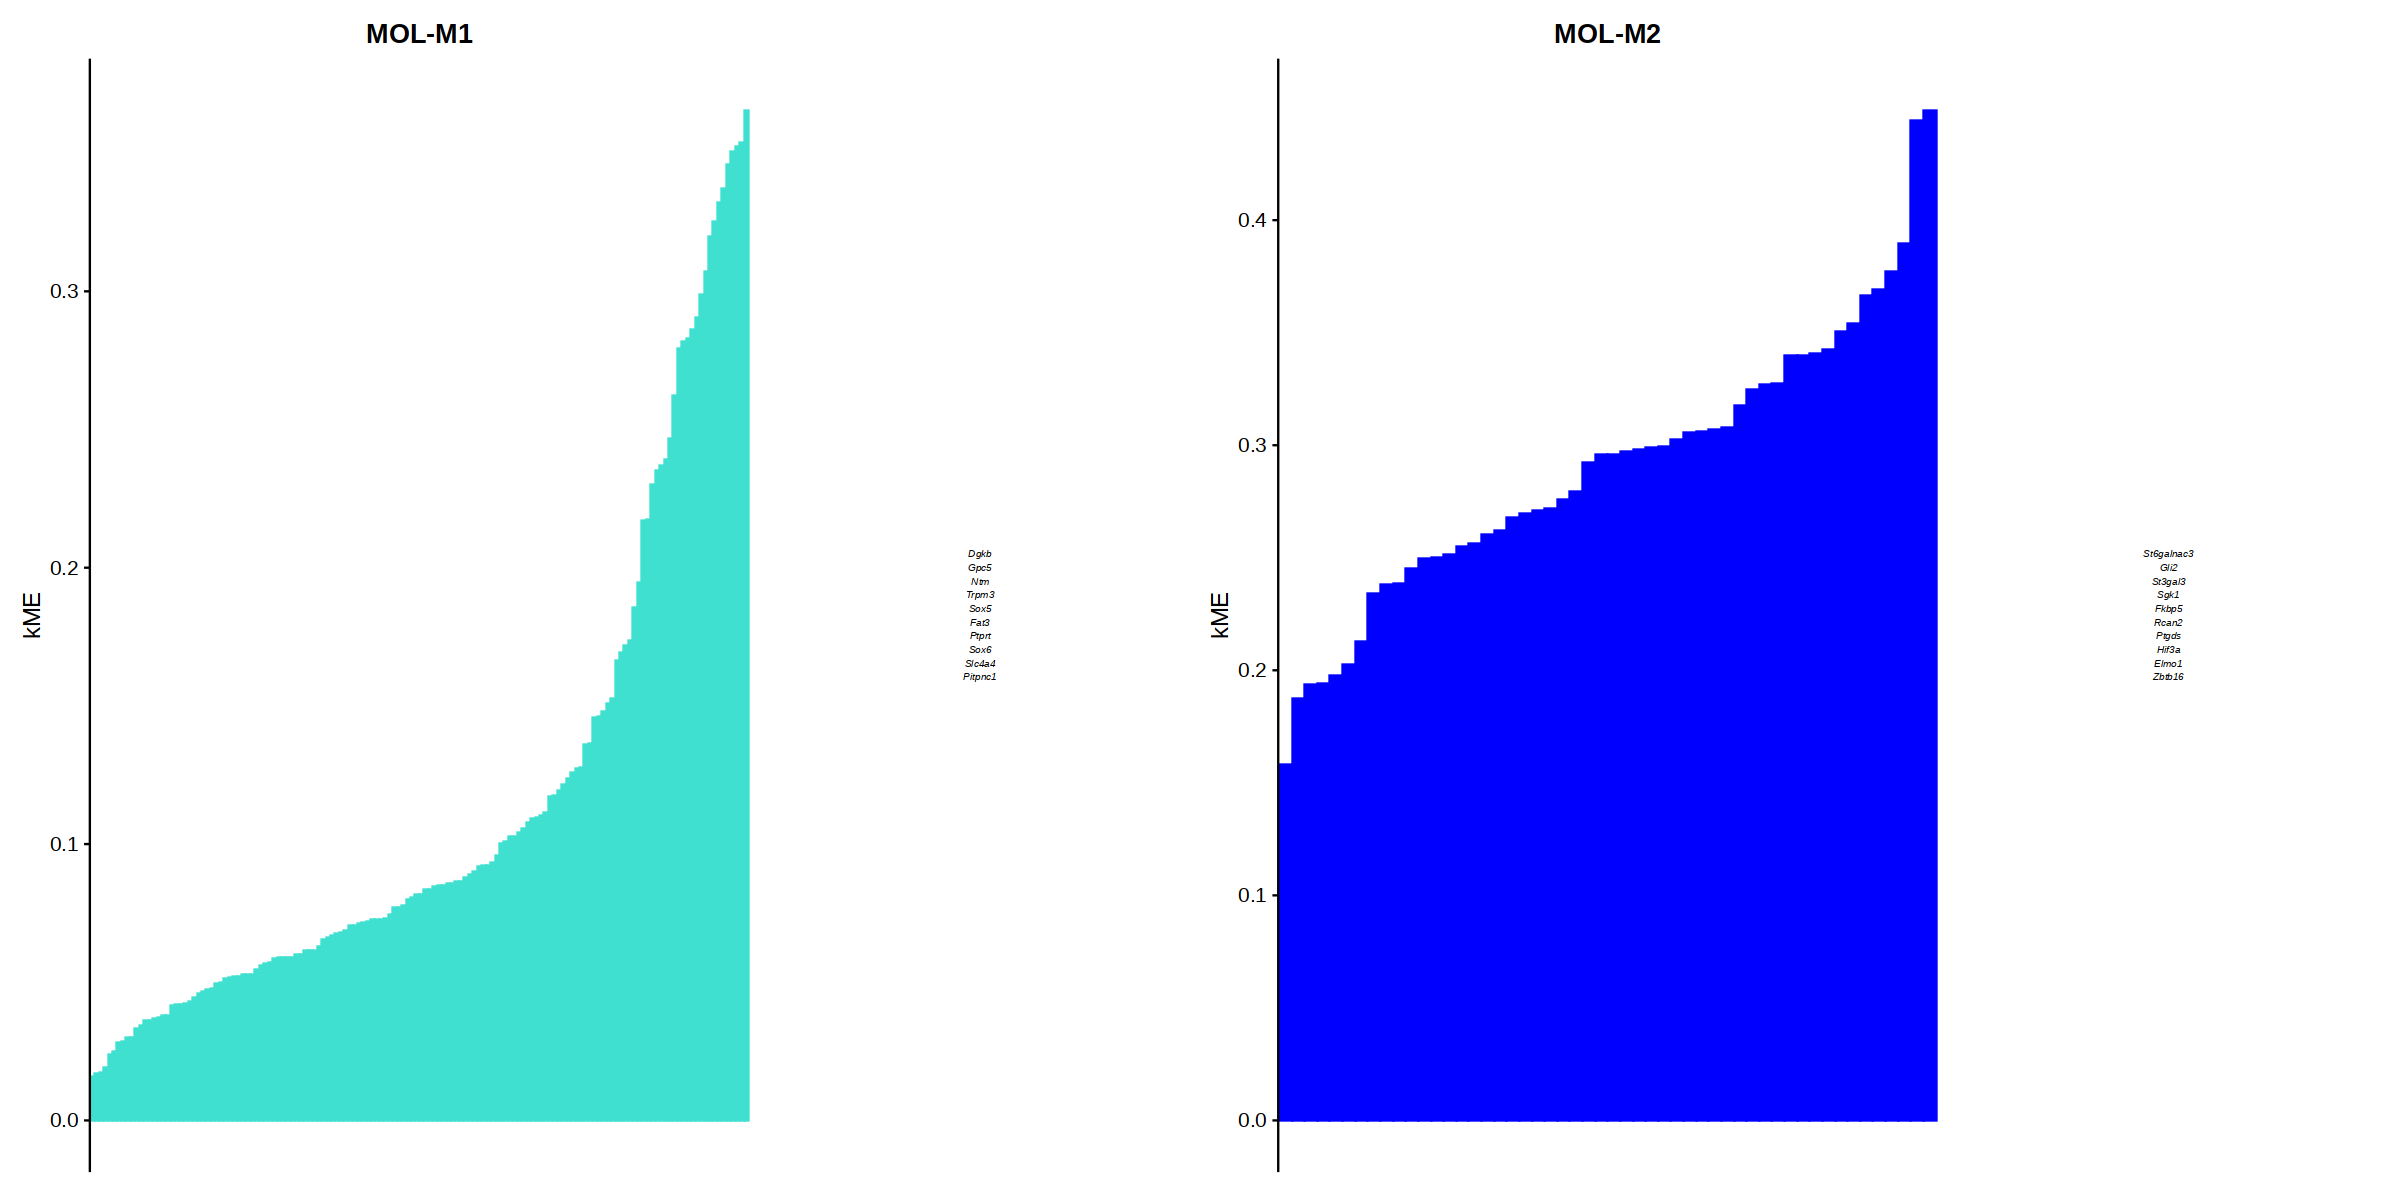

In [37]:
options(repr.plot.width=20, repr.plot.height=10)
p <- PlotKMEs(obj, ncol=2)
p

In [38]:
GetModules(obj)

,gene_name,module,color,kME_grey,kME_MOL-M1,kME_MOL-M2
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
Lypla1,Lypla1,grey,grey,0.0367094594,0.005877468,-0.0156059907
Tcea1,Tcea1,grey,grey,0.0671279243,-0.017300558,0.0174578929
Atp6v1h,Atp6v1h,grey,grey,0.0862126884,0.001866539,0.0330985813
Rb1cc1,Rb1cc1,grey,grey,0.0847884771,-0.030016745,0.0465768803
St18,St18,grey,grey,0.1224291453,-0.112347796,0.0080841045
Pcmtd1,Pcmtd1,grey,grey,-0.0514966979,0.005502804,0.0281461358
Rrs1,Rrs1,grey,grey,0.1198133326,-0.060962003,0.0511510484
Sgk3,Sgk3,grey,grey,0.0954837756,-0.026485856,0.1218875106
Cspp1,Cspp1,grey,grey,0.0647507489,-0.026303784,0.0155236376


In [39]:
big_obj = qs::qread('obj_metacells_processed.qs')

In [40]:
big_obj

An object of class Seurat 
59498 features across 144643 samples within 3 assays 
Active assay: SCT (27177 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [41]:
modules = GetModules(obj)

In [ ]:
new_obj =  ScaleData(big_obj, features=VariableFeatures(big_obj))
new_obj = ModuleEigengenes(
  new_obj,
  group.by.vars="hash.mcl.ID",
  modules = modules,
  vars.to.regress = NULL,
  scale.model.use = "linear",
  verbose = TRUE,
  assay = NULL,
  pc_dim = 1,
  exclude_grey = FALSE,
  wgcna_name = NULL
)

Centering and scaling data matrix



[1] "grey"


Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 1 features requested have zero variance (running reduction without them): B230206H07Rik"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_"
pcagrey_ 1 
Positive:  Nfia, Qk, Dock1, Arap2, Npas3, Nfib, Gramd3, Phlpp1, Zeb2, Cyp2j9 
	   Ndrg2, Acss1, Trps1, Stard13, Kank1, Acsl3, Hepacam, Zcchc24, Sparcl1, Megf10 
	   2610035D17Rik, Cecr2, Plekhg1, Cyp2j6, Gpm6b, Nfix, Cdk19, Itih3, Abca1, Cdh20 
Negative:  Ipw, Erc2, Ptprn2, Ank3, Nrg3, ENSMUSG00000097311, Rims1, Gabrb3, Cacna1e, Usp29 
	   Myt1l, Cacna1b, Ube3a, Dscam, Grin2b, Cntnap2, Cacna1c, Dlgap2, Dlg2, Rit2 
	   Celf4, Ahi1, Meg3, Xkr4, Cadps, Unc79, Ksr2, Sntg1, Cdr1os, ENSMUSG00000097451 


In [45]:
new_obj

An object of class Seurat 
59498 features across 144643 samples within 3 assays 
Active assay: SCT (27177 features, 3000 variable features)
 2 other assays present: RNA, integrated
 2 dimensional reductions calculated: pca, umap

In [52]:
qs::qsave(new_obj, 'new_obj.qs')

In [ ]:
new_obj = qs::qread('new_obj.qs')

In [51]:
# compute all MEs in the full single-cell dataset
options(mc.cores = 20)
new_obj <- ModuleEigengenes(
 new_obj,
 group.by.vars="hash.mcl.ID",
 modules=modules
)

[1] "grey"


Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
"The following 1 features requested have zero variance (running reduction without them): B230206H07Rik"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_"
pcagrey_ 1 
Positive:  Nfia, Qk, Dock1, Arap2, Npas3, Nfib, Gramd3, Phlpp1, Zeb2, Cyp2j9 
	   Ndrg2, Acss1, Trps1, Stard13, Kank1, Acsl3, Hepacam, Zcchc24, Sparcl1, Megf10 
	   2610035D17Rik, Cecr2, Plekhg1, Cyp2j6, Gpm6b, Nfix, Cdk19, Itih3, Abca1, Cdh20 
Negative:  Ipw, Erc2, Ptprn2, Ank3, Nrg3, ENSMUSG00000097311, Rims1, Gabrb3, Cacna1e, Usp29 
	   Myt1l, Cacna1b, Ube3a, Dscam, Grin2b, Cntnap2, Cacna1c, Dlgap2, Dlg2, Rit2 
	   Celf4, Ahi1, Meg3, Xkr4, Cadps, Unc79, Ksr2, Sntg1, Cdr1os, ENSMUSG00000097451 


[1] "MOL-M1"


Centering and scaling data matrix

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaMOL-M1 to pcaMOLM1_"
Warning message:
"All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaMOLM1_"
pcaMOLM1_ 1 
Positive:  Slc1a3, Slc4a4, Slc39a12, Slc1a2, Gli3, Lhfp, Plpp3, Prex2, ENSMUSG00000097156, Lrig1 
	   Plce1, Mapk4, Arhgef26, Nhsl1, Mertk, Slc6a11, Sox6, Pitpnc1, Wdr17, Malat1 
	   Spon1, Slc7a11, Glis3, Ptch1, Msi2, Bcl2, Tcf7l2, Mir99ahg, Sfxn5, Pard3b 
Negative:  Snhg11, Nalf1, Prkg1, Kcnip4, Fgf14, Gria2, Gabrg3, Asic2, Cacna1d, Grid1 
	   Cacnb2, Rtn1, Frmd4a, Nrxn3, Dlgap1, Agbl4, Rgs7, Mapk10, Arhgap26, Gabrb1 
	   Astn1, Efna5, Map2, Astn2, Shisa9, Gpm6a, Ldb2, Celf2, Ctnnd2, Kcnd2 
pcaMOLM1_ 2 
Positive:  Col23a1, Ddx5, Malat1, Ogt, Efna5, Slit2, Pdlim5, Pard3b, Tcf7l2, Pcsk1n 
	   Cst3, Rfx3, Asap1, Rmst, Sox6, Glis3, Apoe, Cacnb2, Msi2, Actb 
	   Mir99ahg, Son, Nx

ERROR: Error in harmonize(harmonyObj, max.iter.harmony, verbose): terminated by user


In [ ]:
2